## Final Project Submission

* Student name: **Wendy Kim**
* Student pace: **Part time**
* Instructor name: **Jeff Herman**
* Blog post URL: https://wendysjkim.github.io/improving_profitability_using_monte_carlo_simulation


In this project, I will be analyzing the Northwind database, a free, open-source dataset created by Microsoft containing data from a fictional company. I will be investigating various aspects such as revenue or quantity sold by discount level, product category, shipping region, and etc. Then, I will also perform some hypothesis tests to draw potential recommendations to improve Northwind's profitability.

Here's the schema for the Northwind database:

<img src="Northwind_ERD_updated.png">

# 1. Import Data

### Import necessary liabraries

In [1]:
### NOTE: Uncomment after checking each warning ###
import warnings
warnings.filterwarnings("ignore") 

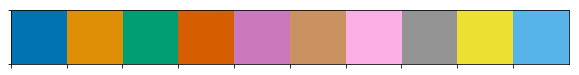

In [2]:
# import necessar libraries
import time
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower

# color palette to use
palette = sns.color_palette("colorblind",10)
sns.set_palette(palette)
sns.palplot(palette)

In [3]:
# set default formatting
sns.set(context='notebook', 
        style='white', 
        palette='colorblind', 
       
        font_scale=1.2, 
        color_codes=True, 
        rc={
             'axes.edgecolor': 'black',
             'axes.facecolor': 'white',
             'axes.grid': False,
             'axes.labelcolor': 'black',
             'axes.spines.right': False,
             'axes.spines.top': False,
             'figure.facecolor': 'white',
             'lines.solid_capstyle': 'round',
             'text.color': 'black',
             'xtick.color': 'black',
             'ytick.color': 'black',
          })

### Import SQL tables

In [4]:
# import Northwind SQL database
c = sqlite3.connect('Northwind_small.sqlite')

In [5]:
# import all SQL tables and preview the data
queries = []
tables = ['Product', 'Supplier', 'Region', "'Order'", 'OrderDetail', 'Category', 
          'Employee', 'EmployeeTerritory', 'Territory', 'Customer', 'CustomerCustomerDemo',
         'CustomerDemographic', 'Shipper']

for i in range(len(tables)):
    query = 'SELECT * FROM {}'.format(tables[i])
    queries.append(query)

d = {}
for indx, table in enumerate(tables):
    d[table] = pd.read_sql(queries[indx], c)
    print('TABLE: {}, {} obs'.format(table, len(d[table])))
    display(d[table].head(2)) # number of rows to show for each table
    print('--------------------------------------------------------------------------------')

TABLE: Product, 77 obs


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0


--------------------------------------------------------------------------------
TABLE: Supplier, 29 obs


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#


--------------------------------------------------------------------------------
TABLE: Region, 4 obs


,Id,RegionDescription
0,1,Eastern
1,2,Western


--------------------------------------------------------------------------------
TABLE: 'Order', 830 obs


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


--------------------------------------------------------------------------------
TABLE: OrderDetail, 2155 obs


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0


--------------------------------------------------------------------------------
TABLE: Category, 8 obs


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."


--------------------------------------------------------------------------------
TABLE: Employee, 9 obs


,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


--------------------------------------------------------------------------------
TABLE: EmployeeTerritory, 49 obs


,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713


--------------------------------------------------------------------------------
TABLE: Territory, 53 obs


,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1


--------------------------------------------------------------------------------
TABLE: Customer, 91 obs


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745


--------------------------------------------------------------------------------
TABLE: CustomerCustomerDemo, 0 obs


,Id,CustomerTypeId


--------------------------------------------------------------------------------
TABLE: CustomerDemographic, 0 obs


,Id,CustomerDesc


--------------------------------------------------------------------------------
TABLE: Shipper, 3 obs


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199


--------------------------------------------------------------------------------


### Define functions for the analyses

In [6]:
def chk_data(data):
    '''
    Checks duplicates and missing data
    '''
    duplicates = data[data.duplicated()]
    print('-----------------------------------------')
    print('Total number of observations: ', len(data))
    print('Number of Duplicates: ',len(duplicates))
    print('Number of Missing Values: ')
    print(data.isna().sum())
    print('-----------------------------------------')

In [7]:
def monte_carlo(sample1, sample2, n=10000, greater='sample1', plot=False, print_progress=False):
    '''
    Returns p-value
    Performs Monte Carlo simulation of given 2 samples, where
    sample1 : sample (list) to perform the simulation
    sample2 : sample (list) to perform the simulation
    n : number of simulations
    greater : sample that is expected to have greater mean, either sample1 or sample2
    plot : if True, outputs histogram of sample mean differences from the simulation
    print_progress : if True, prints simulation number when n is at 0%, 20%, 40%, 60%, 80% and 100% of given n
    '''
    # identify sample with bigger size
    if len(sample1) >= len(sample2):
        a = list(sample1)
        b = list(sample2)
        if greater == 'sample1':
            test_if_greater = 'a'
            test = 'Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)'
        else:
            test_if_greater = 'b'
            test = 'Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)'
    else:
        a = list(sample2)
        b = list(sample1)
        if greater == 'sample1':
            test_if_greater = 'b'
            test = 'Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)'
        else:
            test_if_greater = 'a'
            test = 'Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)'
    
    # difference of sample means
    mu_diff = np.mean(a) - np.mean(b)

    counter = 0
    combined = a + b
    sample_diffs = []
    
   
    # Run simulations
    print(' ', test)
    if print_progress:
        print('Simulation starting')
    for i in range(n):
        ai = np.random.choice(combined, size=len(a), replace=False)
        bi = combined.copy()

        for element in ai:
            bi.remove(element) #bi is a complement of ai

        mu_diff2 = np.mean(ai) - np.mean(bi)
        sample_diffs.append(mu_diff2)
        
        if test_if_greater == 'a':
            if mu_diff2 > mu_diff:
                counter += 1
        else:
            if mu_diff2 < mu_diff:
                counter += 1
                
        if print_progress:        
            if i in list(np.linspace(0, n, 5)): # print simulation progress 
                t1 = time.time()
                print('Simulation #{}'.format(i))
            
    if print_progress:
        print('Simulation done')
        %%time
    
    p_val = counter / n
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.hist(sample_diffs, label='sample mean diffs')
        plt.axvline(mu_diff, color='k', label='mean diff')

        plt.xlabel('Mean Differences')
        plt.ylabel('Counts')
        plt.suptitle('Distribution of Sample Mean Differences', fontsize= 18)
        plt.title('P-value that {} is greater is {}'.format(greater, np.round(p_val,4)))
#         plt.title(test)
        plt.legend(bbox_to_anchor=(1, 1))
        plt.show()

#     print(test)
    print('  P_value is', np.round(p_val,2))
    return p_val

In [8]:
# Investigate effect size
def cal_cohens_d(sample1, sample2):
    '''
    Calculates effect size (Cohen's D) of given 2 samples. 
    Returns Cohen's d and if the effect size is small, medium, or large.
    
    d = (mu1 - mu2) / (sqrt(std1**2 + std2**2) / 2)
    Where
    mu1 = mean of sample 1
    mu2 = mean of sample 2
    std1 = standard deviation of sample 1
    std2 = standard deviation of sample 2
    
    Small effect size: 0 < d < 0.4
    Medium effect size: 0.4 <= d < 0.8
    Large effect size: d >= 0.8
    '''
    d = (np.mean(sample1)- np.mean(sample2))/(np.sqrt(np.std(sample1)**2+np.std(sample2)**2)/2)
    
    if d == 0:
        size = 'No Effect'
    elif np.abs(d) < 0.4:
        size = 'Small'
    elif np.abs(d) >= 0.8:
        size = 'Large'
    else:
        size = 'Medium'
        
    return (d, size)

While a p-value tells whether an effect exists, it does not reveal the size of the effect. 

Statistical significance is the probability that the observed difference between two groups is due to chance. When a sample size is large enough, a statistical test will almost always conclude that there exists significant difference, unless the effect size is zero. Thus, it is important to report effect size as well.


According to Cohen, “a medium effect of .5 is visible to the naked eye of a careful observer. A small effect of .2 is noticeably smaller than medium but not so small as to be trivial. A large effect of .8 is the same distance above the medium as small is below it.”

In [9]:
# Investigate statistical power
power_analysis = TTestIndPower()

def cal_power(sample1, sample2, effect, alpha=0.05):
    '''
    Calculates statistical power using TTestIndPower function from statsmodels library,
    given effect size and alpha.
    '''
    n1 = len(sample1)
    n2 = len(sample2)
    power = power_analysis.solve_power(nobs1=n1, ratio=n2/n1, effect_size=effect, alpha=alpha)
    
    return power

**Statistical power is the probability that an actual difference exists when the study shows a statistically significant difference.** Higher statistical power means higher likelihood of correctly deciding that there is an actual effect.Power is 1-β, where β is the probability of incorrectly concluding there is no effect when one actually exists (Type II error). 

Like statistical significance, statistical power depends upon effect size and sample size. If the effect size of the intervention is large, it is possible to detect such an effect in smaller sample numbers, whereas a smaller effect size would require larger sample sizes. Huge sample sizes may detect differences that are quite small and possibly trivial.

Methods to increase the power of your study include using more potent interventions that have bigger effects, increasing the size of the sample/subjects, reducing measurement error (use highly valid outcome measures), and raising the α level but only if making a Type I error is highly unlikely.

# 2. Discount Amount & Quantity Ordered

Effect of discount amount on the quantity ordered for each product in an order.

### 2a. Explore the dataset

In [10]:
od = d['OrderDetail']
chk_data(od) # Check for missing or erraneous values

-----------------------------------------
Total number of observations:  2155
Number of Duplicates:  0
Number of Missing Values: 
Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64
-----------------------------------------


In [11]:
# Quantities of sales without discount 
qty_nodiscount = od[od['Discount'] == 0]['Quantity']
qty_nodiscount.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [12]:
# Quantities of sales with discount 
qty_discount = od[od['Discount'] > 0]['Quantity']
qty_discount.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

#### **Investigate at Discount Level**

In [13]:
qty_discount_breakdown = od[od['Discount'] > 0][['Quantity', 'Discount']]
qty_discount_breakdown.head()

,Quantity,Discount
6,35,0.15
7,15,0.15
8,6,0.05
9,15,0.05
11,40,0.05


In [14]:
qty_discount_breakdown.groupby('Discount').size()

Discount
0.01      1
0.02      2
0.03      3
0.04      1
0.05    185
0.06      1
0.10    173
0.15    157
0.20    161
0.25    154
dtype: int64

Based on the value counts of each discount, it seems reasonable to group discount levels less than 10% together.

In [15]:
# create discount group & discount level columns
od['Discount_Group'] = od['Discount'].astype(str) # string discount groups
od.loc[(od['Discount'] < 0.10) &
       (od['Discount'] > 0), 'Discount_Group'] = '<0.10'

for indx, group in enumerate(od['Discount_Group'].unique()): # numeric discount groups
    od.loc[(od['Discount_Group'] == group, 'Discount_Level')] = indx + 1

od.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_Group,Discount_Level
0,10248/11,10248,11,14.0,12,0.0,0.0,1.0
1,10248/42,10248,42,9.8,10,0.0,0.0,1.0
2,10248/72,10248,72,34.8,5,0.0,0.0,1.0
3,10249/14,10249,14,18.6,9,0.0,0.0,1.0
4,10249/51,10249,51,42.4,40,0.0,0.0,1.0


#### **Investigate at Product Level**

In [16]:
# assign discout flag 
od2 = od[['ProductId', 'Discount','Quantity']]
od2.loc[od2['Discount'] == 0, 'Discount_flag'] = 'N'
od2.loc[od2['Discount'] != 0, 'Discount_flag'] = 'Y'

# calculate average quantity ordered by product and discount flag
disc = pd.DataFrame(od2.groupby(['ProductId', 'Discount_flag']).mean().reset_index()).drop('Discount', axis=1)

disc_p = disc.pivot(index='ProductId', columns='Discount_flag').reset_index()
disc_p.columns = disc_p.columns.map(' '.join).str.strip()

# calculate difference in average quantity ordered in each group
disc_p['Qty_Diff'] = disc_p['Quantity Y'] - disc_p['Quantity N']

# merge in product category
prod_cat = d['Product'][['Id', 'ProductName', 'CategoryId',]]
disc_p = disc_p.merge(prod_cat, how='left', left_on='ProductId', right_on='Id').drop('Id', axis=1)
disc_p = disc_p.sort_values(['CategoryId','Qty_Diff','ProductId'], ascending=False).reset_index()

disc_p.head()

,index,ProductId,Quantity N,Quantity Y,Qty_Diff,ProductName,CategoryId
0,36,37,11.750000,39.000000,27.250000,Gravad lax,8
1,57,58,18.714286,36.636364,17.922078,Escargots de Bourgogne,8
2,39,40,22.880000,33.187500,10.307500,Boston Crab Meat,8
3,44,45,31.428571,41.142857,9.714286,Rogede sild,8
4,9,10,19.454545,28.545455,9.090909,Ikura,8


### 2b. Data Visualization

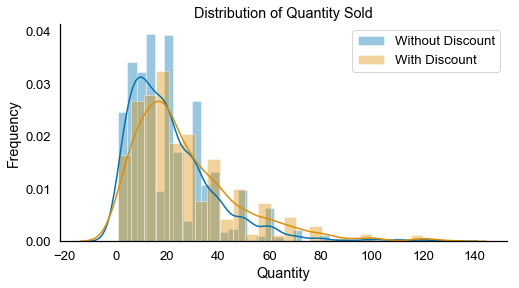

In [17]:
# Plot histogram of the quantities, with & without discount
plt.figure(figsize=(8,4))
sns.distplot(qty_nodiscount, kde=True, hist_kws=dict(alpha=0.4), label='Without Discount')
sns.distplot(qty_discount, kde=True, hist_kws=dict(alpha=0.4), label='With Discount')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.title('Distribution of Quantity Sold')
plt.legend()
plt.show()

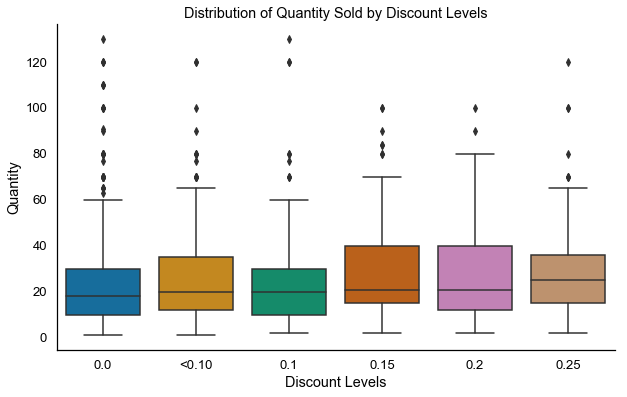

In [18]:
# Distribution of quantity at discount level
plt.figure(figsize=(10,6))
sns.boxplot(x='Discount_Group', y='Quantity', data=od, order=['0.0', '<0.10', '0.1', '0.15', '0.2', '0.25'])
plt.xlabel('Discount Levels')
plt.ylabel('Quantity')
plt.title('Distribution of Quantity Sold by Discount Levels')
plt.show()

When looking at distribution of quantity order by each discount levels, it is difficult to tell the diffrence between each distributions. The distributions are skewed to the right. 

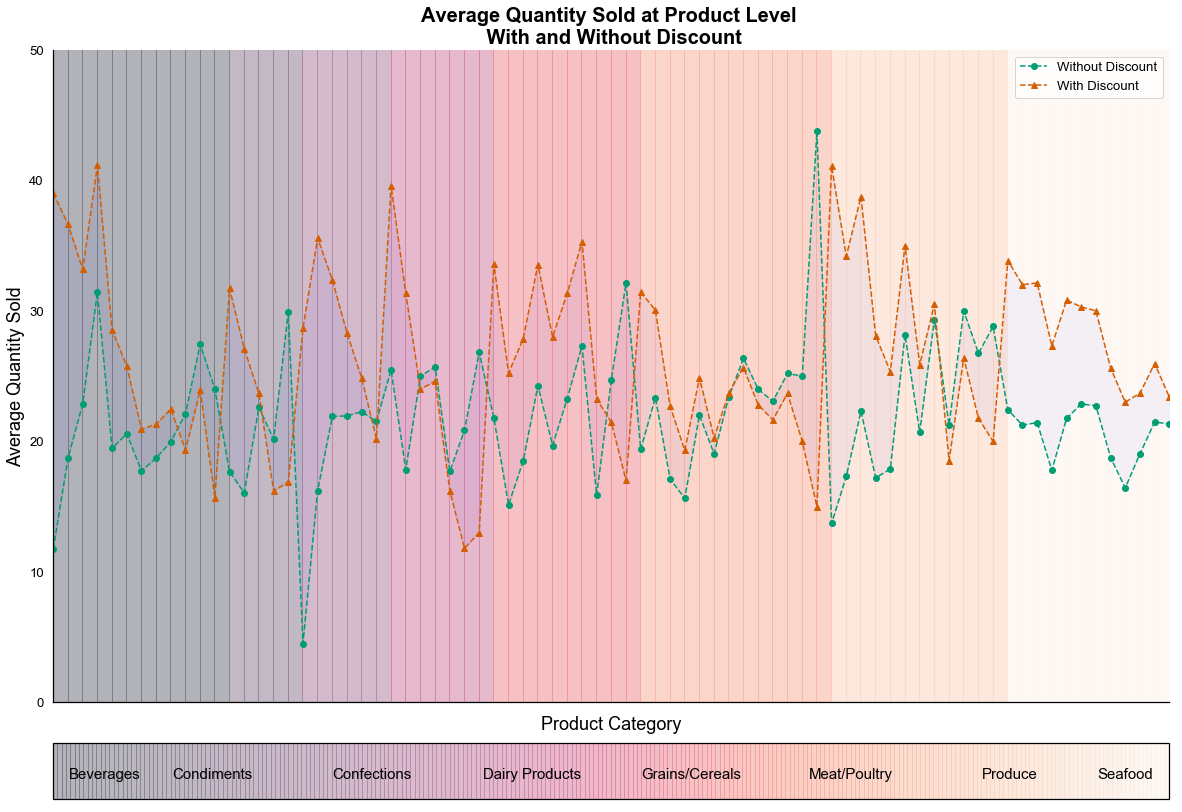

In [19]:
# Difference between average quantity sold at product level
plt.figure(figsize=(20,15))
plt.plot(disc_p.index, 'Quantity N', 'go--' ,label='Without Discount', data=disc_p)
plt.plot(disc_p.index, 'Quantity Y', 'r^--' ,label='With Discount', data=disc_p)

# color area between two lines
plt.fill_between(disc_p.index, disc_p['Quantity Y'], disc_p['Quantity N'], color='blue', alpha=0.05)

# formatting
plt.title('Average Quantity Sold at Product Level \n With and Without Discount', weight='heavy', size=20)
plt.ylabel('Average Quantity Sold', size=18)
plt.xlabel('Product Category', size=18)
# plt.xticks(np.arange(0,77,1), labels=disc_p['ProductName'] ,rotation=90)
plt.xticks(np.arange(0,77,1), labels=[])
plt.xlim(0,76)
plt.legend()

# color plot background based on product category
x, y = np.meshgrid(disc_p.index, [0,50])
z = np.meshgrid(disc_p['CategoryId'] * -1 + 8)
plt.pcolor(x, y, z, alpha=0.3)

cb = plt.colorbar(orientation='horizontal', ticks=[], pad=0.05)
cb_label = list(d['Category']['CategoryName'])

for i in range(8):
    if (i == 0) :
        cb.ax.text(i+0.1, 3, cb_label[i], ha='left', va='center', color='black', size=15)
    elif (i == 7):
        cb.ax.text(i-0.1, 3, cb_label[i], ha='right', va='center', color='black', size=15)
    else:
        cb.ax.text(i, 3, cb_label[i], ha='center', va='center', color='black', size=15)

plt.show()

When we look at differences in average quantities sold with and without dicsount, at product level, average quantities sold tend to be higher when there is discount.

### 2c. Hypothesis Test

The distribution is not normal, skewed to the right. Also, the samples are not of equal size. It'd be more appropriate to use Welch's t-test rather than student's t-test.

- $H_0$ : $\mu_d = \mu_{nd}$
- $H_a$ : $\mu_d > \mu_{nd}$

In [20]:
# Welch's T-test
result = stats.ttest_ind(qty_nodiscount, qty_discount, equal_var=False) # very small p-value
pval = result[1] / 2
pval

2.828207145152165e-10

  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
Simulation starting
Simulation #0
Simulation #2500
Simulation #5000
Simulation #7500
Simulation done
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 39.1 µs


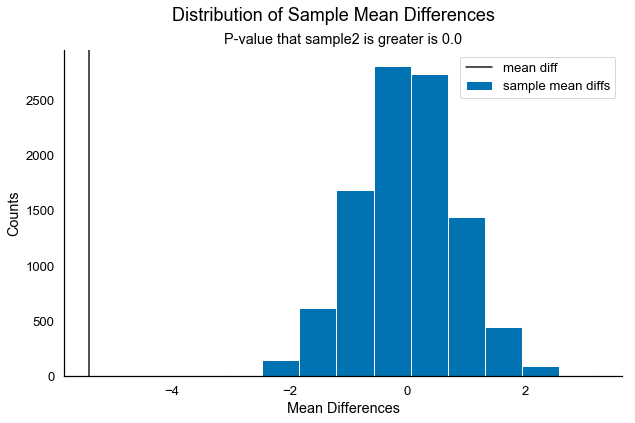

  P_value is 0.0


In [21]:
# monte carlo simulation
mc_1 = monte_carlo(qty_nodiscount, qty_discount, n=10000, greater='sample2', plot=True, print_progress=True)

Both Welch's t-test and monte calro simulation give very small p-value, suggesting the difference in means of two distributions are statistically significant. The null hypothesis that means of two discount groups (with or without) are identical is rejected.

Next, we look into if similar conclusion can be drawn from different levels of discounts.

In [22]:
# run multiple t-tests to compare different discount groups
results_1t = []
alpha = 0.05

rates = list(od['Discount_Level'].unique()) # numeric labels of the discount groups
rates_label = list(od['Discount_Group'].unique()) # string labels of the discount groups

for rate1 in rates:
    rates_comp = [x for x in rates if x > rate1] # only compare to the discounts bigger than rate1
    print('---')
    for rate2 in rates_comp:
#         print('comparing {} and {}'.format(rate1, rate2))
        print('comparing {} and {}'.format(rates_label[int(rate1-1)], rates_label[int(rate2-1)]))
        sample1 = od[od['Discount_Level'] == rate1]['Quantity']
        sample2 = od[od['Discount_Level'] == rate2]['Quantity']

        result = stats.ttest_ind(sample1, sample2, equal_var=False)

        if result[1]/2 < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next discount group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_1t.append([rates_label[int(rate1-1)], 
                        rates_label[int(rate2-1)], 
                        result[1], 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_1t = pd.DataFrame(results_1t, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_1t

---
comparing 0.0 and 0.15
comparing 0.0 and <0.10
comparing 0.0 and 0.2
comparing 0.0 and 0.25
comparing 0.0 and 0.1
---
comparing 0.15 and <0.10
---
comparing <0.10 and 0.2
---
comparing 0.2 and 0.25
---
comparing 0.25 and 0.1
---


,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,0.0,0.15,0.000172,Rejected,-0.489741,Medium,0.999938
1,0.0,<0.10,0.002174,Rejected,-0.367495,Small,0.997484
2,0.0,0.2,0.000811,Rejected,-0.413742,Medium,0.998616
3,0.0,0.25,0.000159,Rejected,-0.490280,Medium,0.999926
4,0.0,0.1,0.037456,Rejected,-0.256754,Small,0.887428


In [23]:
# run monte carlo simulation to compare different discount groups
results_1m = []
alpha = 0.05

rates = list(od['Discount_Level'].unique()) # numeric labels of the discount groups
rates_label = list(od['Discount_Group'].unique()) # string labels of the discount groups

for rate1 in rates:
    rates_comp = [x for x in rates if x > rate1] # only compare to the discounts bigger than rate1
    print('---')
    for rate2 in rates_comp:
#         print('---')
        print('comparing {} and {}'.format(rates_label[int(rate1-1)], rates_label[int(rate2-1)]))
        
        sample1 = od[od['Discount_Level'] == rate1]['Quantity']
        sample2 = od[od['Discount_Level'] == rate2]['Quantity']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample2', plot=False, print_progress=False)

        if p_val < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next discount group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_1m.append([rates_label[int(rate1-1)], 
                        rates_label[int(rate2-1)], 
                        p_val, 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_1m = pd.DataFrame(results_1m, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_1m

---
comparing 0.0 and 0.15
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing 0.0 and <0.10
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing 0.0 and 0.2
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing 0.0 and 0.25
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing 0.0 and 0.1
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.01
---
comparing 0.15 and <0.10
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.74
---
comparing <0.10 and 0.2
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.47
---
comparing 0.2 and 0.25
  Testing if sampl

,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,0.0,0.15,0.0000,Rejected,-0.489741,Medium,0.999938
1,0.0,<0.10,0.0000,Rejected,-0.367495,Small,0.997484
2,0.0,0.2,0.0001,Rejected,-0.413742,Medium,0.998616
3,0.0,0.25,0.0000,Rejected,-0.490280,Medium,0.999926
4,0.0,0.1,0.0089,Rejected,-0.256754,Small,0.887428


Similar conclusion can be drawn then quantity ordered differs when there is (or isn't) discounts. However, when looking among groups with certain discount levels, the differences are not statistically significant. Even when comparing those with and without discounts, we can see the effect size is small for discounts levels less than or equal to 10%.

We can interpret this result as:
- Quantities sold tend to increase when there is discount higher than 10%
- Beyond the 10% discount, the effect of discount amount on quantities sold is not statistically significant.

# 3. Product Category, Discount & Revenue

Effect of product category and discount on the revenue generated by a product in an order

### 3a. Explore the dataset

In [24]:
prod = d['Product']
chk_data(prod)

-----------------------------------------
Total number of observations:  77
Number of Duplicates:  0
Number of Missing Values: 
Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
dtype: int64
-----------------------------------------


In [25]:
q1 = """
     SELECT o.OrderDate,
            od.ID as od_ID, od.OrderID, od.ProductID, od.UnitPrice,
            od.Quantity, od.Discount, (od.UnitPrice * od.Quantity) as Revenue,
            
            p.UnitPrice as RetailPrice, (od.UnitPrice - p.UnitPrice) as UnitPrice_Diff,
            p.CategoryId
            
     FROM OrderDetail as od
     
     LEFT JOIN 'Order' as o
     ON od.OrderId = o.Id
     
     LEFT JOIN Product as p
     ON od.ProductID = p.Id;
     """
revenue= pd.read_sql(q1, c)
# add discount group flags
revenue.loc[revenue['Discount'] == 0, 'Discount Flag'] = 'N'
revenue.loc[revenue['Discount'] != 0, 'Discount Flag'] = 'Y'
revenue.head()

,OrderDate,od_ID,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue,RetailPrice,UnitPrice_Diff,CategoryId,Discount Flag
0,2012-07-04,10248/11,10248,11,14.0,12,0.0,168.0,21.00,-7.00,4,N
1,2012-07-04,10248/42,10248,42,9.8,10,0.0,98.0,14.00,-4.20,5,N
2,2012-07-04,10248/72,10248,72,34.8,5,0.0,174.0,34.80,0.00,4,N
3,2012-07-05,10249/14,10249,14,18.6,9,0.0,167.4,23.25,-4.65,7,N
4,2012-07-05,10249/51,10249,51,42.4,40,0.0,1696.0,53.00,-10.60,7,N


In [26]:
chk_data(revenue)

-----------------------------------------
Total number of observations:  2155
Number of Duplicates:  0
Number of Missing Values: 
OrderDate         0
od_ID             0
OrderId           0
ProductId         0
UnitPrice         0
Quantity          0
Discount          0
Revenue           0
RetailPrice       0
UnitPrice_Diff    0
CategoryId        0
Discount Flag     0
dtype: int64
-----------------------------------------


In [27]:
category = d['Category']
category

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


### 3b. Data Visualization

In [28]:
print('First Order: ', min(revenue['OrderDate']))
print('Last Order: ', max(revenue['OrderDate']))

First Order:  2012-07-04
Last Order:  2014-05-06


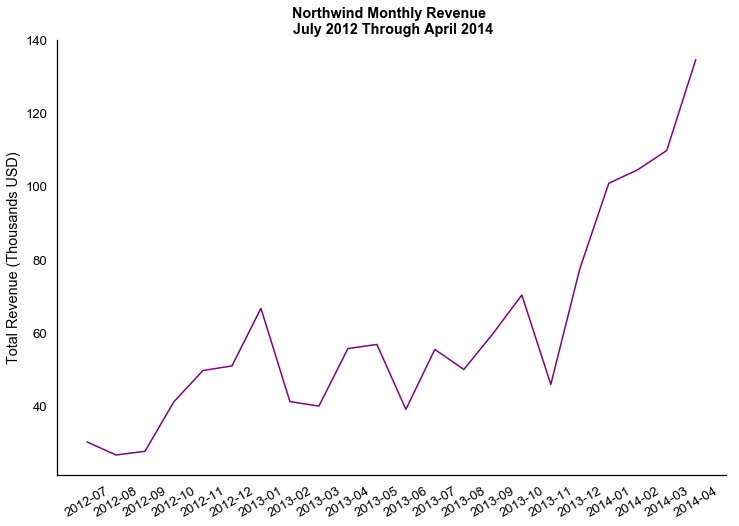

In [29]:
plt.figure(figsize=(12,8))
# calulcate monthly revenue
revenue['OrderDate'] = pd.to_datetime(revenue['OrderDate'], format= "%Y-%m-%d")
rev_month = pd.DataFrame(revenue.groupby([revenue['OrderDate'].dt.strftime('%Y-%m')])['Revenue'].sum()).reset_index()
rev_plot = rev_month.iloc[:-1,:] #exclude 2014 May revenue, since data is only available up to 5/6/2014

plt.plot(rev_plot.index.values, rev_plot['Revenue']/1000, color='purple')
plt.title('Northwind Monthly Revenue \n July 2012 Through April 2014', weight='heavy')
plt.xticks(range(22), rev_plot['OrderDate'], rotation=30)
plt.ylabel('Total Revenue (Thousands USD)')
plt.show()

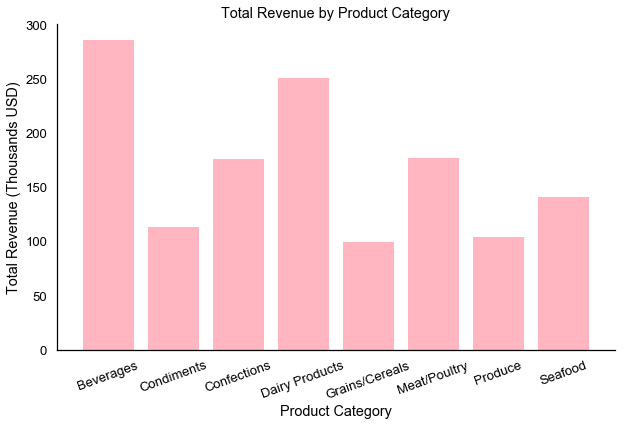

In [30]:
plt.figure(figsize=(10,6))
rev_cat = revenue.groupby(['CategoryId'])['Revenue'].sum()
plt.bar(np.arange(1,9), height=rev_cat/1000, color='lightpink')
plt.title('Total Revenue by Product Category')
plt.xticks(np.arange(1,9), category['CategoryName'], rotation=20)
plt.xlabel('Product Category')
plt.ylabel('Total Revenue (Thousands USD)')
plt.show()

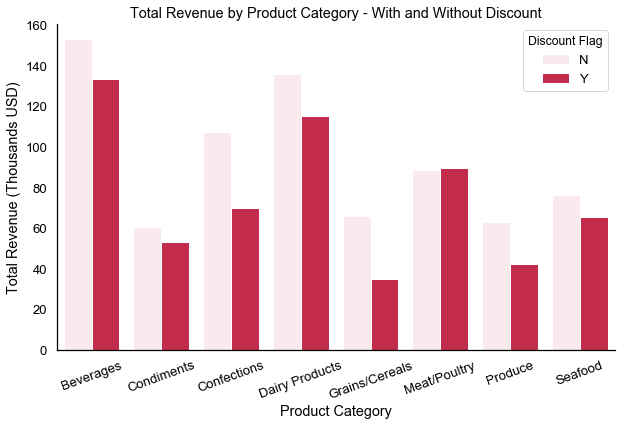

In [31]:
plt.figure(figsize=(10,6))
rev_disc = revenue.groupby(['CategoryId','Discount Flag'])['Revenue'].sum().reset_index()
sns.barplot(x='CategoryId', y=rev_disc['Revenue']/1000, 
            hue='Discount Flag', data=rev_disc, ci=None, color='crimson')

plt.title('Total Revenue by Product Category - With and Without Discount')
plt.xticks(np.arange(0,8), category['CategoryName'], rotation=20)
plt.xlabel('Product Category')
plt.ylabel('Total Revenue (Thousands USD)')
plt.show()

The trend in total revenue by product category remains consistent among groups with discount and without dsicount. Beverages and dairy products are two most revenue-generating product categories. In the previous section, we concluded that discount has statistically significant impact on the quantity ordered. Does discount amount also have statistically significant impact on total revenue? The graph above shows that total revenue tend to be higher when there is no discount. 

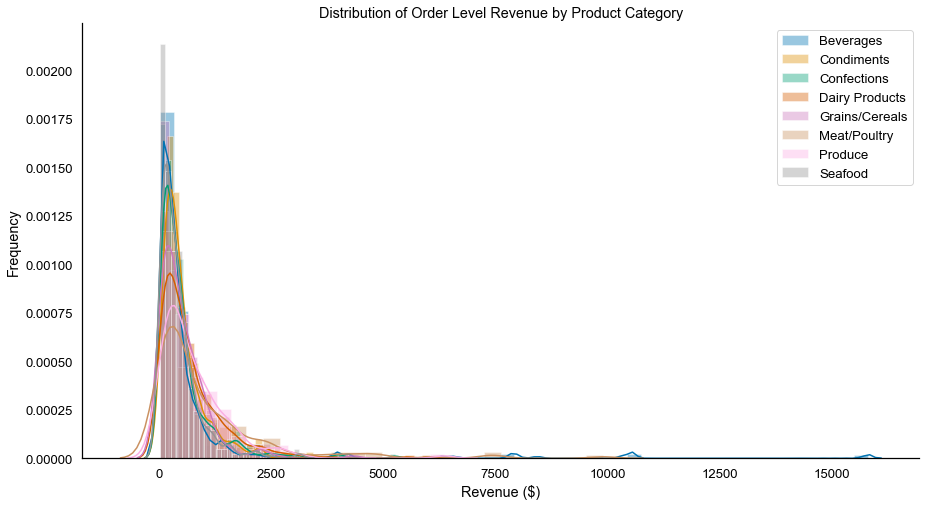

In [32]:
plt.figure(figsize=(15,8))
for i in range(8):
    sns.distplot(revenue.loc[revenue['CategoryId'] == i+1, 'Revenue'], label=i)
plt.legend(labels=category['CategoryName'])
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Order Level Revenue by Product Category')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

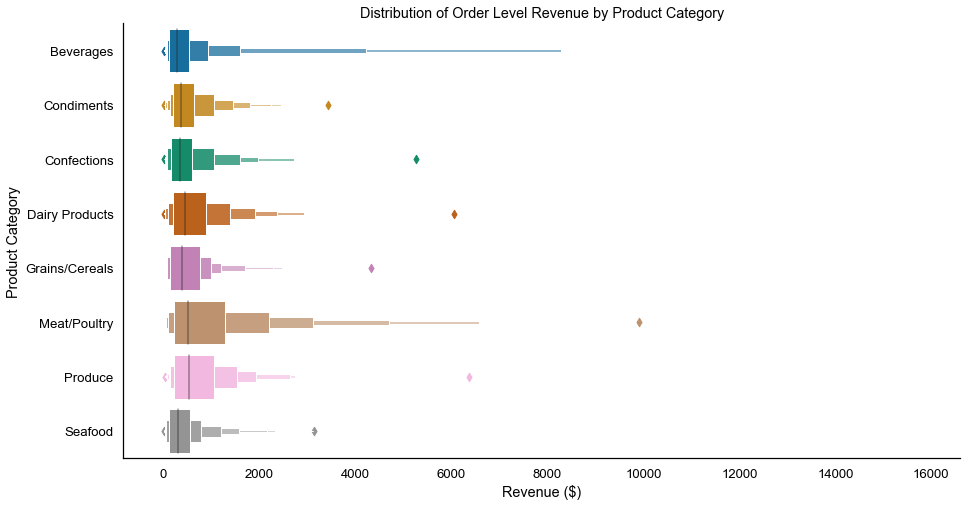

In [33]:
plt.figure(figsize=(15,8))
sns.boxenplot(y='CategoryId', x='Revenue', data=revenue, orient='horizontal', color=None)

plt.xlabel('Revenue ($)')
plt.ylabel('Product Category')
plt.yticks(ticks=range(8), labels=category['CategoryName'])
plt.title('Distribution of Order Level Revenue by Product Category')
plt.show()

The distributions are skewed to the right.

### 3c. Hypothesis Test

Since we are comparing impact of two factors on the revenue simulatenously, we would run ANOVA analysis.

In [34]:
revenue.head()

,OrderDate,od_ID,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue,RetailPrice,UnitPrice_Diff,CategoryId,Discount Flag
0,2012-07-04,10248/11,10248,11,14.0,12,0.0,168.0,21.00,-7.00,4,N
1,2012-07-04,10248/42,10248,42,9.8,10,0.0,98.0,14.00,-4.20,5,N
2,2012-07-04,10248/72,10248,72,34.8,5,0.0,174.0,34.80,0.00,4,N
3,2012-07-05,10249/14,10249,14,18.6,9,0.0,167.4,23.25,-4.65,7,N
4,2012-07-05,10249/51,10249,51,42.4,40,0.0,1696.0,53.00,-10.60,7,N


In [35]:
test = revenue[['Revenue', 'CategoryId', 'Discount']]
test.head()

,Revenue,CategoryId,Discount
0,168.0,4,0.0
1,98.0,5,0.0
2,174.0,4,0.0
3,167.4,7,0.0
4,1696.0,7,0.0


In [36]:
formula = 'Revenue ~ C(CategoryId) + Discount'
lm = ols(formula, test).fit()
table = sm.stats.anova_lm(lm, type=2)
print(table)

                   df        sum_sq       mean_sq         F        PR(>F)
C(CategoryId)     7.0  5.580441e+07  7.972059e+06  7.608988  4.299573e-09
Discount          1.0  9.760987e+06  9.760987e+06  9.316442  2.298914e-03
Residual       2146.0  2.248399e+09  1.047716e+06       NaN           NaN


The p-values for product category and discount level are very small, indicating both of the factors have significant impact on the revenue.

# 4. Price, Quantity & Revenue

Effect of price on the revenue/quantity generated by a product in an order

### 4a. Explore the dataset

In [37]:
revenue.head()

,OrderDate,od_ID,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue,RetailPrice,UnitPrice_Diff,CategoryId,Discount Flag
0,2012-07-04,10248/11,10248,11,14.0,12,0.0,168.0,21.00,-7.00,4,N
1,2012-07-04,10248/42,10248,42,9.8,10,0.0,98.0,14.00,-4.20,5,N
2,2012-07-04,10248/72,10248,72,34.8,5,0.0,174.0,34.80,0.00,4,N
3,2012-07-05,10249/14,10249,14,18.6,9,0.0,167.4,23.25,-4.65,7,N
4,2012-07-05,10249/51,10249,51,42.4,40,0.0,1696.0,53.00,-10.60,7,N


In [38]:
chk_data(revenue)

-----------------------------------------
Total number of observations:  2155
Number of Duplicates:  0
Number of Missing Values: 
OrderDate         0
od_ID             0
OrderId           0
ProductId         0
UnitPrice         0
Quantity          0
Discount          0
Revenue           0
RetailPrice       0
UnitPrice_Diff    0
CategoryId        0
Discount Flag     0
dtype: int64
-----------------------------------------


In [39]:
revenue['UnitPrice'].describe()

count    2155.000000
mean       26.218520
std        29.827418
min         2.000000
25%        12.000000
50%        18.400000
75%        32.000000
max       263.500000
Name: UnitPrice, dtype: float64

In [40]:
# create unit price groups
levels = [(0,5), (5,10), (10,15), (15,20), (20,30), (30,40), (40,50), (50,300)]
i = 1

prices = [] # numeric labels of the unit price groups
prices_label = [] # string labels of the unit price groups

for level in levels:
    a = level[0]
    b = level[1]
    
    revenue.loc[(revenue['UnitPrice'] > a) & 
                (revenue['UnitPrice'] <= b), 'UnitPrice_Group'] = '{}-{}'.format(a,b) #string group label
    revenue.loc[(revenue['UnitPrice'] > a) & 
                (revenue['UnitPrice'] <= b), 'UnitPrice_GroupNum'] = i #numeri group label

    prices_label.append('{}-{}'.format(a,b))
    prices.append(i)
    
    i += 1
    
revenue['UnitPrice_Group'].value_counts(normalize=False)

15-20     391
5-10      387
10-15     341
30-40     335
20-30     323
50-300    163
40-50     124
0-5        91
Name: UnitPrice_Group, dtype: int64

### 4b. Data Visualization

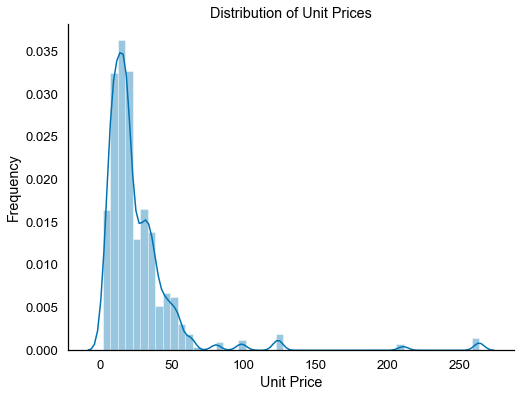

In [41]:
plt.figure(figsize=(8,6))
sns.distplot(revenue['UnitPrice'])
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.title('Distribution of Unit Prices')
plt.show()

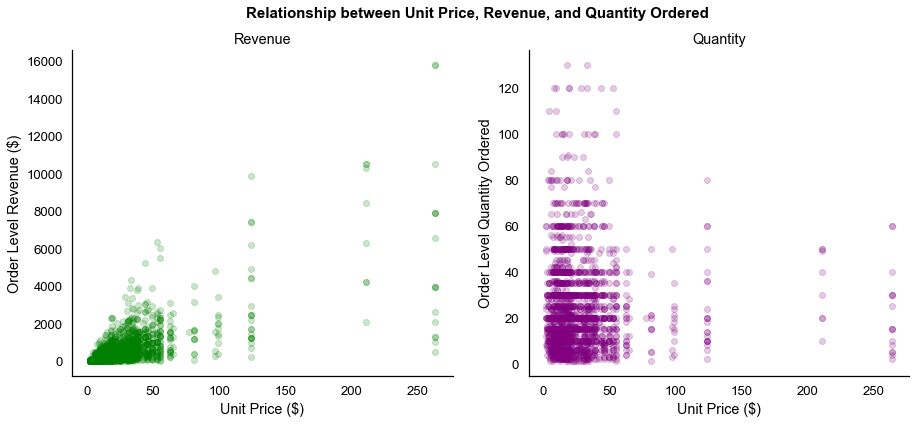

In [42]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.scatter('UnitPrice', 'Revenue', data=revenue, alpha=0.2, color='green')
plt.xlabel('Unit Price ($)')
plt.ylabel('Order Level Revenue ($)')
plt.title('Revenue')

plt.subplot(1,2,2)
plt.scatter('UnitPrice', 'Quantity', data=revenue, alpha=0.2, color='purple')
plt.xlabel('Unit Price ($)')
plt.ylabel('Order Level Quantity Ordered')
plt.title('Quantity')

plt.suptitle('Relationship between Unit Price, Revenue, and Quantity Ordered', weight='heavy', size=15)
plt.show()

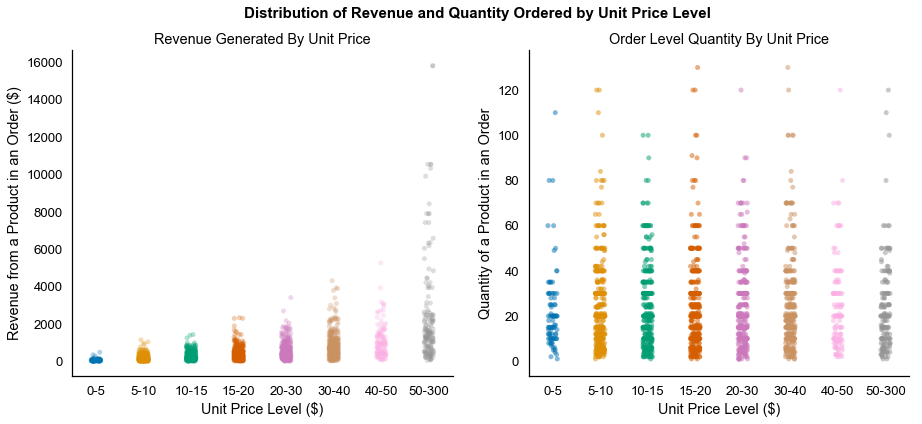

In [43]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
ax1 = sns.stripplot(x='UnitPrice_GroupNum', y='Revenue', data=revenue, orient='v', ax=axes[0], alpha=0.3)
ax1.set_title('Revenue Generated By Unit Price')
ax1.set_xlabel('Unit Price Level ($)')
ax1.set_xticks(ticks=range(8))
ax1.set_xticklabels(prices_label)
ax1.set_ylabel('Revenue from a Product in an Order ($)')

ax2 = sns.stripplot(x='UnitPrice_GroupNum', y='Quantity', data=revenue, orient='v', ax=axes[1], alpha=0.5)
ax2.set_title('Order Level Quantity By Unit Price')
ax2.set_xlabel('Unit Price Level ($)')
ax2.set_xticks(ticks=range(8))
ax2.set_xticklabels(prices_label)
ax2.set_ylabel('Quantity of a Product in an Order')

plt.suptitle('Distribution of Revenue and Quantity Ordered by Unit Price Level', weight='heavy', size=15)
plt.show()

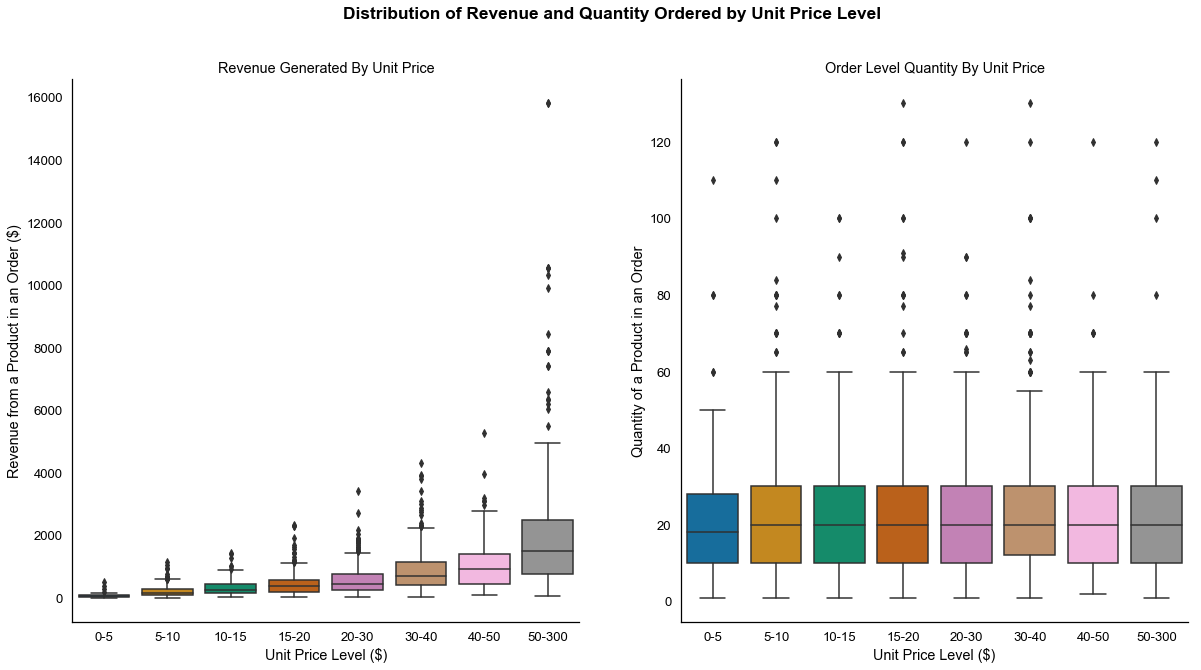

In [44]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ax1 = sns.boxplot(x='UnitPrice_GroupNum', y='Revenue', data=revenue, orient='v', ax=axes[0])
ax1.set_title('Revenue Generated By Unit Price')
ax1.set_xlabel('Unit Price Level ($)')
ax1.set_xticks(ticks=range(8))
ax1.set_xticklabels(prices_label)
ax1.set_ylabel('Revenue from a Product in an Order ($)')

ax2 = sns.boxplot(x='UnitPrice_GroupNum', y='Quantity', data=revenue, orient='v', ax=axes[1])
ax2.set_title('Order Level Quantity By Unit Price')
ax2.set_xlabel('Unit Price Level ($)')
ax2.set_xticks(ticks=range(8))
ax2.set_xticklabels(prices_label)
ax2.set_ylabel('Quantity of a Product in an Order')

plt.suptitle('Distribution of Revenue and Quantity Ordered by Unit Price Level', weight='heavy')
plt.show()

The graphs above suggest that there is a slight positive relationship between unit price and revenue. On the other hand, the distribution of quantity ordered seems to stay fairly consistent for different unit price levels.

### 4c. Hypothesis Test

Again, it'd be more appropriate to use Welch's t-test rather than student's t-test as the distributions are skewed to the right with unequal sample sizes.

- $H_0$ : $Revenue_{price1} = Revenue_{price2}$
- $H_a$ : $Revenue_{price1} < Revenue_{price2}$

Simiarly,
- $H_0$ : $Revenue_{qty1} = Revenue_{qty2}$
- $H_a$ : $Revenue_{qty1} < Revenue_{qty2}$

#### Price & Revenue

In [45]:
# run multiple t-tests to compare different unit price groups
results_2t = []
alpha = 0.05

for price1 in prices:
    prices_comp = [x for x in prices if x > price1] # only compare to the discounts bigger than rate1
    print('---')
    for price2 in prices_comp:
        
        print('comparing {} and {}'.format(prices_label[int(price1-1)], prices_label[int(price2-1)]))
        sample1 = revenue[revenue['UnitPrice_GroupNum'] == price1]['Revenue']
        sample2 = revenue[revenue['UnitPrice_GroupNum'] == price2]['Revenue']

        result = stats.ttest_ind(sample1, sample2, equal_var=False)

        if result[1]/2 < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next unit price group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_2t.append([prices_label[int(price1-1)], 
                        prices_label[int(price2-1)], 
                        result[1], 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_2t = pd.DataFrame(results_2t, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_2t

---
comparing 0-5 and 5-10
comparing 0-5 and 10-15
comparing 0-5 and 15-20
comparing 0-5 and 20-30
comparing 0-5 and 30-40
comparing 0-5 and 40-50
comparing 0-5 and 50-300
---
comparing 5-10 and 10-15
comparing 5-10 and 15-20
comparing 5-10 and 20-30
comparing 5-10 and 30-40
comparing 5-10 and 40-50
comparing 5-10 and 50-300
---
comparing 10-15 and 15-20
comparing 10-15 and 20-30
comparing 10-15 and 30-40
comparing 10-15 and 40-50
comparing 10-15 and 50-300
---
comparing 15-20 and 20-30
comparing 15-20 and 30-40
comparing 15-20 and 40-50
comparing 15-20 and 50-300
---
comparing 20-30 and 30-40
comparing 20-30 and 40-50
comparing 20-30 and 50-300
---
comparing 30-40 and 40-50
comparing 30-40 and 50-300
---
comparing 40-50 and 50-300
---


,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,0-5,5-10,4.397698e-23,Rejected,-1.323487,Large,1.000000
1,0-5,10-15,6.243377e-47,Rejected,-1.957831,Large,1.000000
2,0-5,15-20,8.291283e-57,Rejected,-1.961994,Large,1.000000
3,0-5,20-30,4.743623e-54,Rejected,-2.107610,Large,1.000000
4,0-5,30-40,7.038339e-61,Rejected,-2.234820,Large,1.000000
5,0-5,40-50,1.324557e-24,Rejected,-2.318842,Large,1.000000
6,0-5,50-300,3.610777e-20,Rejected,-1.659526,Large,1.000000
7,5-10,10-15,8.843139e-15,Rejected,-0.845900,Large,1.000000
8,5-10,15-20,8.040523e-29,Rejected,-1.195727,Large,1.000000
9,5-10,20-30,8.167315e-36,Rejected,-1.531409,Large,1.000000


In [46]:
# run monte carlo simulation to compare different unit price groups
results_2m = []
alpha = 0.05

for price1 in prices:
    prices_comp = [x for x in prices if x > price1] # only compare to the discounts bigger than rate1
    print('---')
    for price2 in prices_comp:
        
        print('comparing {} and {}'.format(prices_label[int(price1-1)], prices_label[int(price2-1)]))
        sample1 = revenue[revenue['UnitPrice_GroupNum'] == price1]['Revenue']
        sample2 = revenue[revenue['UnitPrice_GroupNum'] == price2]['Revenue']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample2', plot=False, print_progress=False)

        if p_val < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next discount group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_2m.append([prices_label[int(price1-1)], 
                        prices_label[int(price2-1)], 
                        p_val, 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_2m = pd.DataFrame(results_2m, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_2m

---
comparing 0-5 and 5-10
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 10-15
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 15-20
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 20-30
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 30-40
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 40-50
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing 0-5 and 50-300
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
---
comparing 5-10 and 10-15
  Testing if sample2 i

,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,0-5,5-10,0.0000,Rejected,-1.323487,Large,1.000000
1,0-5,10-15,0.0000,Rejected,-1.957831,Large,1.000000
2,0-5,15-20,0.0000,Rejected,-1.961994,Large,1.000000
3,0-5,20-30,0.0000,Rejected,-2.107610,Large,1.000000
4,0-5,30-40,0.0000,Rejected,-2.234820,Large,1.000000
5,0-5,40-50,0.0000,Rejected,-2.318842,Large,1.000000
6,0-5,50-300,0.0000,Rejected,-1.659526,Large,1.000000
7,5-10,10-15,0.0000,Rejected,-0.845900,Large,1.000000
8,5-10,15-20,0.0000,Rejected,-1.195727,Large,1.000000
9,5-10,20-30,0.0000,Rejected,-1.531409,Large,1.000000


#### Price & Quantity

In [47]:
# run multiple t-tests to compare different unit price groups
results_3t = []
alpha = 0.05

for price1 in prices:
    prices_comp = [x for x in prices if x > price1] # only compare to the discounts bigger than rate1
    print('---')
    for price2 in prices_comp:
        
        print('comparing {} and {}'.format(prices_label[int(price1-1)], prices_label[int(price2-1)]))
        sample1 = revenue[revenue['UnitPrice_GroupNum'] == price1]['Quantity']
        sample2 = revenue[revenue['UnitPrice_GroupNum'] == price2]['Quantity']

        result = stats.ttest_ind(sample1, sample2, equal_var=False)

        if result[1]/2 < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next unit price group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_3t.append([prices_label[int(price1-1)], 
                        prices_label[int(price2-1)], 
                        result[1], 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_3t = pd.DataFrame(results_3t, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_3t

---
comparing 0-5 and 5-10
---
comparing 5-10 and 10-15
---
comparing 10-15 and 15-20
---
comparing 15-20 and 20-30
---
comparing 20-30 and 30-40
---
comparing 30-40 and 40-50
---
comparing 40-50 and 50-300
---


,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power


In [48]:
# run monte carlo simulation to compare different unit price groups
results_3m = []
alpha = 0.05

for price1 in prices:
    prices_comp = [x for x in prices if x > price1] # only compare to the discounts bigger than rate1
    print('---')
    for price2 in prices_comp:
        
        print('comparing {} and {}'.format(prices_label[int(price1-1)], prices_label[int(price2-1)]))
        sample1 = revenue[revenue['UnitPrice_GroupNum'] == price1]['Quantity']
        sample2 = revenue[revenue['UnitPrice_GroupNum'] == price2]['Quantity']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample2', plot=False, print_progress=False)

        if p_val < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject' # move on to next discount group when null is rejected
            break

        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_3m.append([prices_label[int(price1-1)], 
                        prices_label[int(price2-1)], 
                        p_val, 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_3m = pd.DataFrame(results_3m, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
results_df_3m

---
comparing 0-5 and 5-10
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.21
---
comparing 5-10 and 10-15
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.32
---
comparing 10-15 and 15-20
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.48
---
comparing 15-20 and 20-30
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.67
---
comparing 20-30 and 30-40
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.19
---
comparing 30-40 and 40-50
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.72
---
comparing 40-50 and 50-300
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.53
---


,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power


The results show that each unit price level has statistically significant impact on the revenue. On the other hand, unit price doesn't have statistically significant impact on quantity ordered. The effect sizes are medium or high as well.

# 5. Region & Revenue

Effect of region on the revenue generated in an order

### 5a. Explore data 

In [49]:
# revenue at order level
q3 = """
     SELECT od.OrderID, SUM(od.UnitPrice * od.Quantity) as Revenue, 
            o.ShipRegion, o.ShipCountry, o.ShipVia, o.Freight
            
     FROM OrderDetail as od
     LEFT JOIN Product as p
     ON od.ProductID = p.Id
     
     LEFT JOIN 'Order' as o
     ON od.'OrderId' = o.'Id'
     
     GROUP BY od.OrderID;
     """
order_ship = pd.read_sql(q3, c)
order_ship.head()

,OrderId,Revenue,ShipRegion,ShipCountry,ShipVia,Freight
0,10248,440.0,Western Europe,France,3,32.38
1,10249,1863.4,Western Europe,Germany,1,11.61
2,10250,1813.0,South America,Brazil,2,65.83
3,10251,670.8,Western Europe,France,1,41.34
4,10252,3730.0,Western Europe,Belgium,2,51.30


In [50]:
# Check for missing or erraneous values
duplicates = order_ship[order_ship.duplicated()]

print('Total number of observations: ', len(order_ship))
print('Number of Duplicates: ',len(duplicates))
order_ship.isna().sum()

Total number of observations:  830
Number of Duplicates:  0


OrderId        0
Revenue        0
ShipRegion     0
ShipCountry    0
ShipVia        0
Freight        0
dtype: int64

In [51]:
order_ship['ShipRegion'].value_counts()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     28
Eastern Europe       7
Name: ShipRegion, dtype: int64

In [52]:
for indx, label in enumerate(order_ship['ShipRegion'].unique()): # add numeric discount groups
    order_ship.loc[(order_ship['ShipRegion'] == label, 'ShipRegion_num')] = indx + 1

order_ship.head()

,OrderId,Revenue,ShipRegion,ShipCountry,ShipVia,Freight,ShipRegion_num
0,10248,440.0,Western Europe,France,3,32.38,1.0
1,10249,1863.4,Western Europe,Germany,1,11.61,1.0
2,10250,1813.0,South America,Brazil,2,65.83,2.0
3,10251,670.8,Western Europe,France,1,41.34,1.0
4,10252,3730.0,Western Europe,Belgium,2,51.30,1.0


In [53]:
pd.DataFrame(d["'Order'"].groupby(['ShipRegion', 'ShipCountry']).size().reset_index())

,ShipRegion,ShipCountry,0
0,British Isles,Ireland,19
1,British Isles,UK,56
2,Central America,Mexico,28
3,Eastern Europe,Poland,7
4,North America,Canada,30
5,North America,USA,122
6,Northern Europe,Denmark,18
7,Northern Europe,Sweden,37
8,Scandinavia,Finland,22
9,Scandinavia,Norway,6


In [54]:
order_ship.groupby(['ShipRegion'])['Revenue'].sum().sort_values(ascending=False)

ShipRegion
Western Europe     537690.50
North America      318901.08
South America      183902.47
British Isles      117933.90
Northern Europe     94305.95
Southern Europe     48605.69
Scandinavia         25513.60
Central America     24073.45
Eastern Europe       3531.95
Name: Revenue, dtype: float64

### 5b. Data Visualization

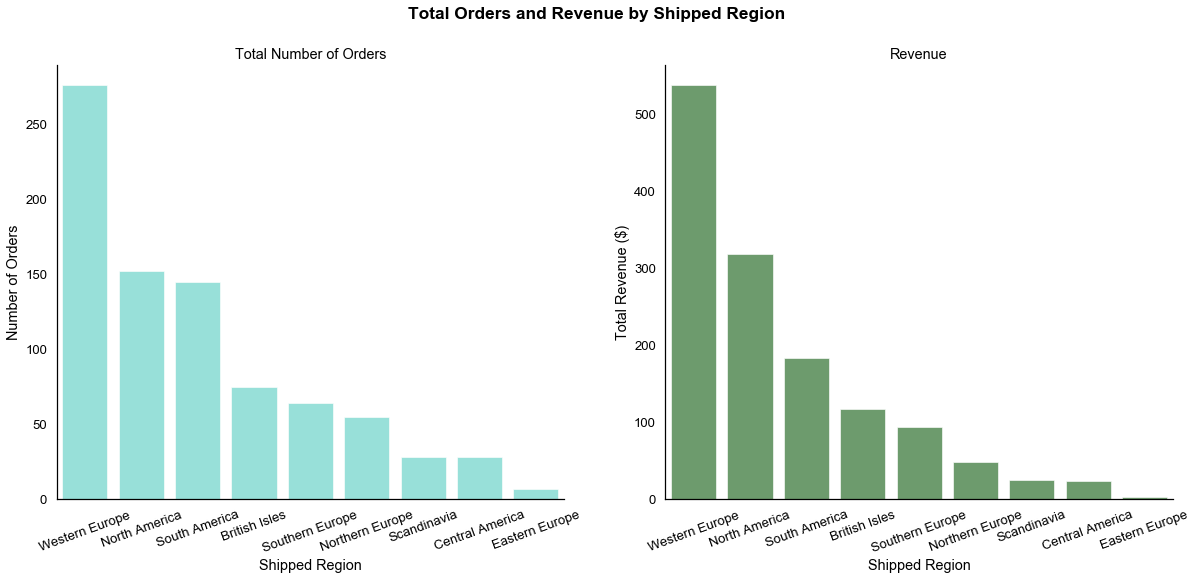

In [55]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
ax1 = sns.countplot(x="ShipRegion", data=d["'Order'"], order=d["'Order'"]['ShipRegion'].value_counts().index, 
                    alpha=0.6, color='turquoise', ax=axes[0])
ax1.set_title('Total Number of Orders')
ax1.set_xlabel('Shipped Region')
ax1.set_xticklabels(d["'Order'"]['ShipRegion'].value_counts().index,rotation=20)
ax1.set_ylabel('Number of Orders')


rev_region = order_ship.groupby(['ShipRegion'])['Revenue'].sum().sort_values(ascending=False)
ax2 = sns.barplot(x=rev_region.index, y=rev_region/1000, color='darkgreen', alpha=0.6, ax=axes[1])

ax2.set_xticklabels(d["'Order'"]['ShipRegion'].value_counts().index,rotation=20)
ax2.set_ylabel('Total Revenue ($)')
ax2.set_xlabel('Shipped Region')
ax2.set_title('Revenue')

plt.suptitle('Total Orders and Revenue by Shipped Region', weight='heavy')
plt.show()

It is interesting to note how South America seems to generate less revenue compared to the total number of orders.

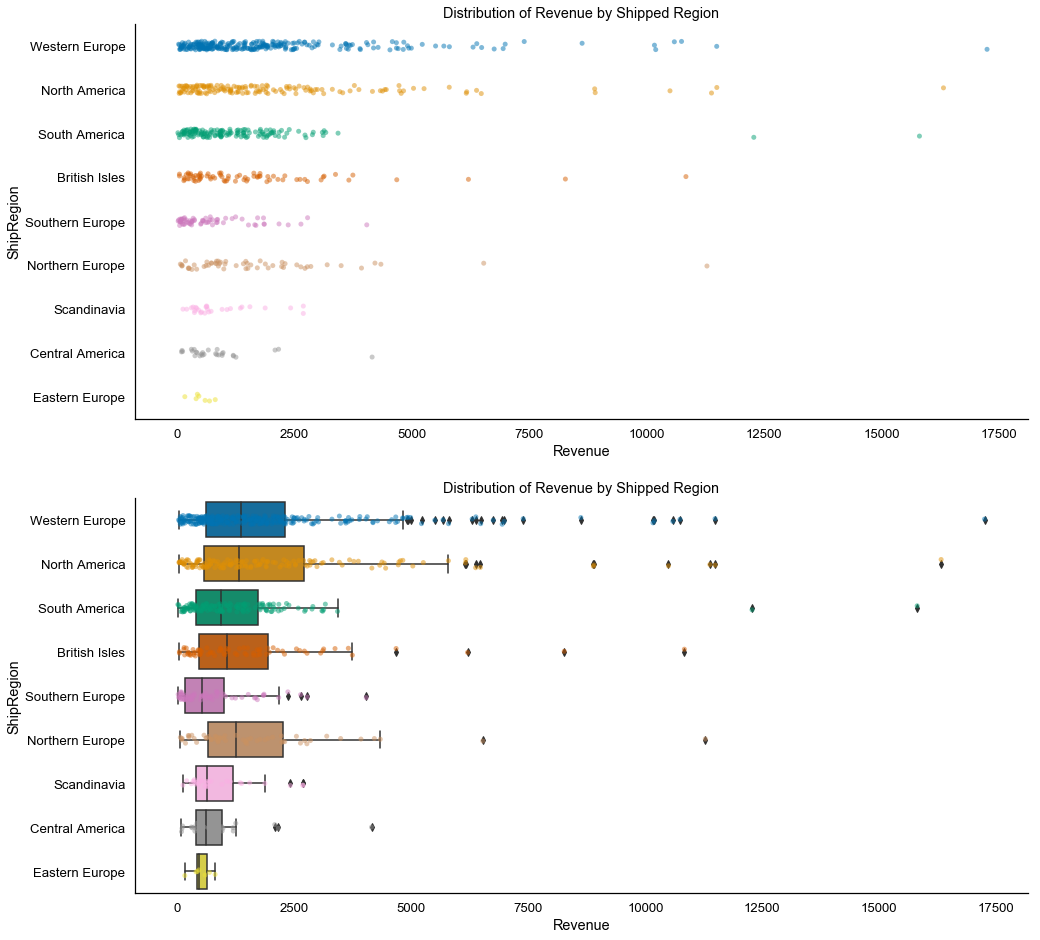

In [56]:
fig, axes = plt.subplots(2,1, figsize=(16,16))
g1 = sns.stripplot(y="ShipRegion", x="Revenue", orient='h',data=order_ship,
                   order=d["'Order'"]['ShipRegion'].value_counts().index, 
                   alpha=0.5, ax=axes[0])
g1.set_title('Distribution of Revenue by Shipped Region')

g2 = sns.boxplot(y="ShipRegion", x="Revenue", orient='h',data=order_ship,
                 order=d["'Order'"]['ShipRegion'].value_counts().index, ax=axes[1])
g2 = sns.stripplot(y="ShipRegion", x="Revenue", orient='h',data=order_ship, 
                   order=d["'Order'"]['ShipRegion'].value_counts().index, 
                   alpha=0.5, ax=axes[1])

g2.set_title('Distribution of Revenue by Shipped Region')
plt.show()

### 5c. Hypothesis Test

Again, we perform Welch's t-test to account for skewed distribution.

- $H_0$ : $Revenue_{reg1} = Revenue_{reg2}$
- $H_a$ : $Revenue_{reg1} > Revenue_{reg2}$

In [57]:
# run multiple t-tests to compare different regions
results_4t = []
alpha = 0.05

regions_num = list(order_ship['ShipRegion_num'].unique()) 
regions = list(order_ship['ShipRegion'].unique())

for reg1 in regions_num:
    for reg2 in regions_num:
        sample1 = order_ship[order_ship['ShipRegion_num'] == reg1]['Revenue']
        sample2 = order_ship[order_ship['ShipRegion_num'] == reg2]['Revenue']

        result = stats.ttest_ind(sample1, sample2, equal_var=False)
        if result[1] /2  < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject'


        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_4t.append([reg1, reg2, result[1], concl, effect[0], effect[1], power, 
                        regions[int(reg1-1)], regions[int(reg2-1)] ])
    
results_df_4t = pd.DataFrame(results_4t, columns=['Group_1', 'Group_2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power', '1_region', '2_region'])
# results_df.loc[results_df['Conclusion'] == 'Rejected']
results_df_4t.head()

,Group_1,Group_2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power,1_region,2_region
0,1.0,1.0,1.000000e+00,Failed to Reject,0.000000,No Effect,0.050000,Western Europe,Western Europe
1,1.0,2.0,5.150605e-04,Rejected,0.491970,Medium,0.997641,Western Europe,South America
2,1.0,3.0,8.534643e-07,Rejected,0.944238,Large,0.997329,Western Europe,Central America
3,1.0,4.0,5.283088e-01,Failed to Reject,-0.092018,Small,0.148690,Western Europe,North America
4,1.0,5.0,4.072385e-01,Failed to Reject,0.165185,Small,0.200224,Western Europe,Northern Europe


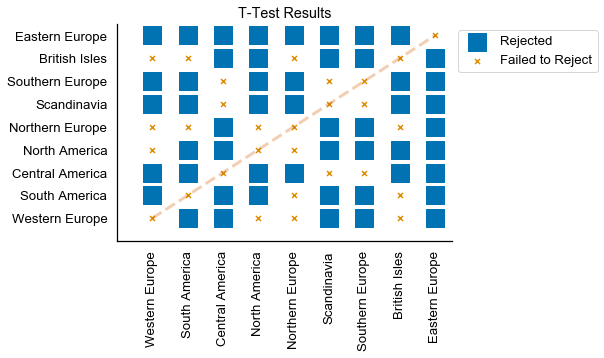

In [58]:
# t-test results
group1 = results_df_4t.loc[results_df_4t['Conclusion'] == 'Rejected']
group2 = results_df_4t.loc[results_df_4t['Conclusion'] == 'Failed to Reject']

plt.scatter('Group_1', 'Group_2', data=group1, marker='s', s=300, label='Rejected')
plt.scatter('Group_1', 'Group_2', data=group2, marker='x', s=25, label='Failed to Reject')
plt.plot(list(range(1,10)), list(range(1,10)), 'r--', linewidth=3, alpha=0.3)

plt.yticks(ticks=np.arange(0,10,1), labels=[''] + regions)
plt.xticks(ticks=np.arange(0,10,1), labels=[''] + regions, rotation=90)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('T-Test Results')
plt.show()

In [59]:
# run monte carlo simulation to compare different regions
results_4m = []
alpha = 0.05

regions_num = list(order_ship['ShipRegion_num'].unique()) 
regions = list(order_ship['ShipRegion'].unique())

for reg1 in regions_num:
    print('----')
    for reg2 in regions_num:
        print('comparing {} and {}'.format(regions[int(reg1-1)], regions[int(reg2-1)]))
        
        sample1 = order_ship[order_ship['ShipRegion_num'] == reg1]['Revenue']
        sample2 = order_ship[order_ship['ShipRegion_num'] == reg2]['Revenue']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample1', plot=False, print_progress=False)
        if p_val  < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject'


        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_4m.append([regions[int(reg1-1)], regions[int(reg2-1)],
                        reg1, reg2, 
                        p_val, 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_4m = pd.DataFrame(results_4m, columns=['Group_1', 'Group_2', 
                                            'Group_1_Num', 'Group_2_Num', 
                                            'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])

----
comparing Western Europe and Western Europe
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.5
comparing Western Europe and South America
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing Western Europe and Central America
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing Western Europe and North America
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.75
comparing Western Europe and Northern Europe
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.23
comparing Western Europe and Scandinavia
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing Western Europe and Southern Europe
  Testing if sample1 

  P_value is 0.99
comparing Scandinavia and Eastern Europe
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.06
----
comparing Southern Europe and Western Europe
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 1.0
comparing Southern Europe and South America
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 1.0
comparing Southern Europe and Central America
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.71
comparing Southern Europe and North America
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 1.0
comparing Southern Europe and Northern Europe
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 1.0
comparing Southern Europe and Scandinavia
 

In [60]:
results_df_4m[results_df_4m['Conclusion'] == 'Rejected']

,Group_1,Group_2,Group_1_Num,Group_2_Num,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
1,Western Europe,South America,1.0,2.0,0.0000,Rejected,0.491970,Medium,0.997641
2,Western Europe,Central America,1.0,3.0,0.0001,Rejected,0.944238,Large,0.997329
5,Western Europe,Scandinavia,1.0,6.0,0.0008,Rejected,0.911574,Large,0.995622
6,Western Europe,Southern Europe,1.0,7.0,0.0000,Rejected,1.031735,Large,1.000000
8,Western Europe,Eastern Europe,1.0,9.0,0.0018,Rejected,1.331450,Large,0.934091
15,South America,Southern Europe,2.0,7.0,0.0010,Rejected,0.534776,Medium,0.943735
17,South America,Eastern Europe,2.0,9.0,0.0160,Rejected,0.879851,Large,0.617578
28,North America,South America,4.0,2.0,0.0002,Rejected,0.555522,Medium,0.997522
29,North America,Central America,4.0,3.0,0.0001,Rejected,0.964035,Large,0.996557
32,North America,Scandinavia,4.0,6.0,0.0006,Rejected,0.933844,Large,0.994710


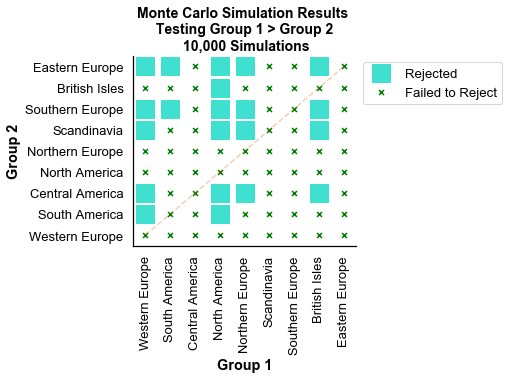

In [61]:
# monte carlo results (sample 1 > sample 2)
plt.figure(figsize=(4,3.5))
group1 = results_df_4m.loc[results_df_4m['Conclusion'] == 'Rejected']
group2 = results_df_4m.loc[results_df_4m['Conclusion'] == 'Failed to Reject']

plt.scatter('Group_1_Num', 'Group_2_Num', data=group1, marker='s', color='turquoise', s=300, label='Rejected')
plt.scatter('Group_1_Num', 'Group_2_Num', data=group2, marker='x', color='green', s=25, label='Failed to Reject')
plt.plot(list(range(1,10)), list(range(1,10)), 'r--', alpha=0.3)

plt.yticks(ticks=np.arange(1,10,1), labels=regions, size=13)
plt.xticks(ticks=np.arange(1,10,1), labels=regions, rotation=90, size=13)
# plt.legend(bbox_to_anchor=(1, -0.65))
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Group 1', weight='heavy')
plt.ylabel('Group 2', weight='heavy')
plt.title('Monte Carlo Simulation Results \n Testing Group 1 > Group 2 \n 10,000 Simulations', 
          size=14, weight='heavy')
plt.show()

In [62]:
# run monte carlo simulation to compare different regions
results_4mb = []
alpha = 0.05

regions_num = list(order_ship['ShipRegion_num'].unique()) 
regions = list(order_ship['ShipRegion'].unique())

for reg1 in regions_num:
    print('----')
    for reg2 in regions_num:
        print('comparing {} and {}'.format(regions[int(reg1-1)], regions[int(reg2-1)]))
        
        sample1 = order_ship[order_ship['ShipRegion_num'] == reg1]['Revenue']
        sample2 = order_ship[order_ship['ShipRegion_num'] == reg2]['Revenue']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample2', plot=False, print_progress=False)
        if p_val  < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject'


        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_4mb.append([regions[int(reg1-1)], regions[int(reg2-1)],
                        reg1, reg2, 
                        p_val, 
                        concl, 
                        effect[0], effect[1], 
                        power])
    
results_df_4mb = pd.DataFrame(results_4mb, columns=['Group_1', 'Group_2', 
                                            'Group_1_Num', 'Group_2_Num', 
                                            'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])

----
comparing Western Europe and Western Europe
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.5
comparing Western Europe and South America
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 1.0
comparing Western Europe and Central America
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 1.0
comparing Western Europe and North America
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.26
comparing Western Europe and Northern Europe
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.77
comparing Western Europe and Scandinavia
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 1.0
comparing Western Europe and Southern Europe
  Testing if sample2 

  P_value is 0.01
comparing Scandinavia and Eastern Europe
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.94
----
comparing Southern Europe and Western Europe
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing Southern Europe and South America
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing Southern Europe and Central America
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.29
comparing Southern Europe and North America
  Testing if sample2 is greater than sample1 where difference = mean(sample2) - mean(sample1)
  P_value is 0.0
comparing Southern Europe and Northern Europe
  Testing if sample2 is greater than sample1 where difference = mean(sample1) - mean(sample2)
  P_value is 0.0
comparing Southern Europe and Scandinavia
 

In [63]:
results_df_4mb.head()

,Group_1,Group_2,Group_1_Num,Group_2_Num,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,Western Europe,Western Europe,1.0,1.0,0.4991,Failed to Reject,0.000000,No Effect,0.050000
1,Western Europe,South America,1.0,2.0,0.9997,Failed to Reject,0.491970,Medium,0.997641
2,Western Europe,Central America,1.0,3.0,0.9997,Failed to Reject,0.944238,Large,0.997329
3,Western Europe,North America,1.0,4.0,0.2623,Failed to Reject,-0.092018,Small,0.148690
4,Western Europe,Northern Europe,1.0,5.0,0.7670,Failed to Reject,0.165185,Small,0.200224


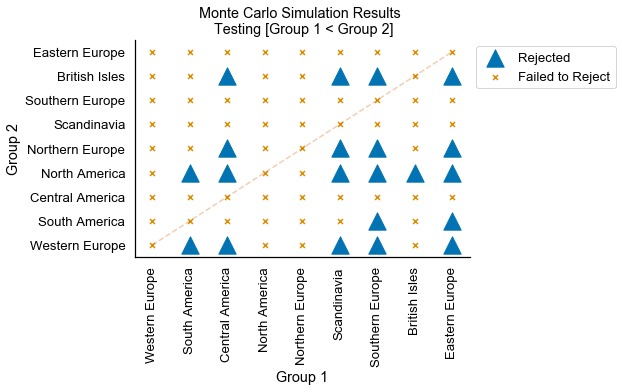

In [64]:
# monte carlo results (sample 2 > sample 1)
group1 = results_df_4mb.loc[results_df_4mb['Conclusion'] == 'Rejected']
group2 = results_df_4mb.loc[results_df_4mb['Conclusion'] == 'Failed to Reject']

plt.scatter('Group_1_Num', 'Group_2_Num', data=group1, marker='^', s=300, label='Rejected')
plt.scatter('Group_1_Num', 'Group_2_Num', data=group2, marker='x', s=25, label='Failed to Reject')
plt.plot(list(range(1,10)), list(range(1,10)), 'r--', alpha=0.3)

plt.yticks(ticks=np.arange(1,10,1), labels=regions)
plt.xticks(ticks=np.arange(1,10,1), labels=regions, rotation=90)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Group 1')
plt.ylabel('Group 2')
plt.title('Monte Carlo Simulation Results \n Testing [Group 1 < Group 2]')
plt.show()

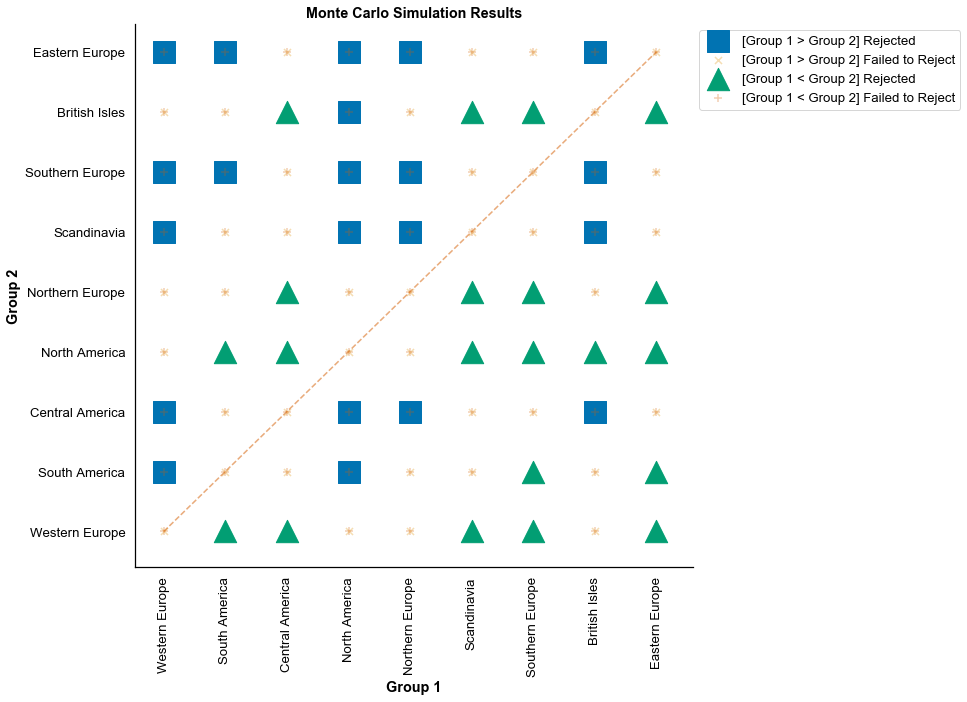

In [65]:
# monte carlo results (combined)
plt.figure(figsize=(10,10))

# sample1 > sample2
group1 = results_df_4m.loc[results_df_4m['Conclusion'] == 'Rejected']
group2 = results_df_4m.loc[results_df_4m['Conclusion'] == 'Failed to Reject']
plt.scatter('Group_1_Num', 'Group_2_Num', data=group1, marker='s', s=500, 
            label='[Group 1 > Group 2] Rejected')
plt.scatter('Group_1_Num', 'Group_2_Num', data=group2, marker='x', s=50, alpha=0.3, 
            label='[Group 1 > Group 2] Failed to Reject')
plt.plot(list(range(1,10)), list(range(1,10)), 'r--', alpha=0.3)


# sample1 < sample2
group1 = results_df_4mb.loc[results_df_4mb['Conclusion'] == 'Rejected']
group2 = results_df_4mb.loc[results_df_4mb['Conclusion'] == 'Failed to Reject']
plt.scatter('Group_1_Num', 'Group_2_Num', data=group1, marker='^', s=500, 
            label='[Group 1 < Group 2] Rejected')
plt.scatter('Group_1_Num', 'Group_2_Num', data=group2, marker='+', s=50, alpha=0.3,
            label='[Group 1 < Group 2] Failed to Reject')
plt.plot(list(range(1,10)), list(range(1,10)), 'r--', alpha=0.3)



plt.yticks(ticks=np.arange(1,10,1), labels=regions)
plt.xticks(ticks=np.arange(1,10,1), labels=regions, rotation=90)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Group 1', weight='heavy')
plt.ylabel('Group 2', weight='heavy')
plt.title('Monte Carlo Simulation Results', weight='heavy')
plt.show()

The results show that Eastern Europe's revenue is significantly less than those of other regions. The effect sizes are medium/large as well, except between North America and British Isles.

# 6. Ship Company & Freight

Effect of shipping company on freight amount

### 6a. Explore Data

In [66]:
order_ship.head()

,OrderId,Revenue,ShipRegion,ShipCountry,ShipVia,Freight,ShipRegion_num
0,10248,440.0,Western Europe,France,3,32.38,1.0
1,10249,1863.4,Western Europe,Germany,1,11.61,1.0
2,10250,1813.0,South America,Brazil,2,65.83,2.0
3,10251,670.8,Western Europe,France,1,41.34,1.0
4,10252,3730.0,Western Europe,Belgium,2,51.30,1.0


### 6b. Data Visualization

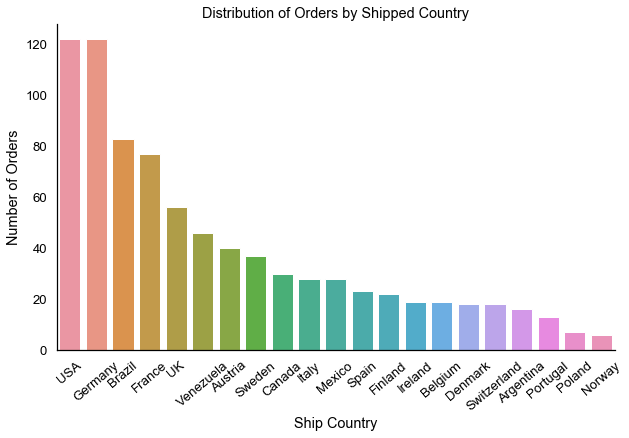

In [67]:
plt.figure(figsize=(10,6))
sns.countplot(x="ShipCountry", data=d["'Order'"], order=d["'Order'"]['ShipCountry'].value_counts().index)
plt.xticks(rotation=40)
plt.ylabel('Number of Orders')
plt.xlabel('Ship Country')
plt.title('Distribution of Orders by Shipped Country')
plt.show()

In [68]:
order_ship.groupby(by='ShipCountry')['Revenue'].median().sort_values(ascending=False).index

Index(['Austria', 'Ireland', 'Switzerland', 'Belgium', 'Sweden', 'USA',
       'Germany', 'Canada', 'Venezuela', 'Denmark', 'Brazil', 'Portugal', 'UK',
       'France', 'Norway', 'Finland', 'Mexico', 'Italy', 'Poland', 'Argentina',
       'Spain'],
      dtype='object', name='ShipCountry')

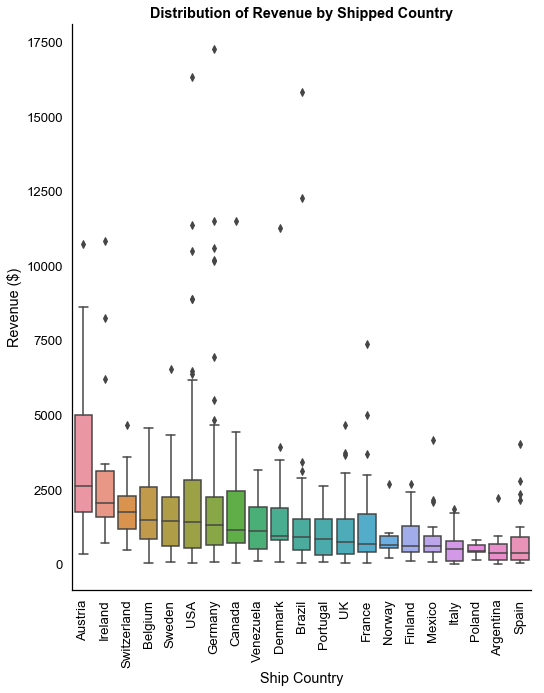

In [69]:
g = sns.catplot(x="ShipCountry", y="Revenue", kind='box', orient='v',data=order_ship,
               order=order_ship.groupby(by='ShipCountry')['Revenue'].median().sort_values(ascending=False).index)
g.fig.set_figheight(10)
g.fig.set_figwidth(9)
plt.xticks(rotation=90)
plt.xlabel('Ship Country')
plt.ylabel('Revenue ($)')
plt.title('Distribution of Revenue by Shipped Country', weight='heavy')
plt.show()

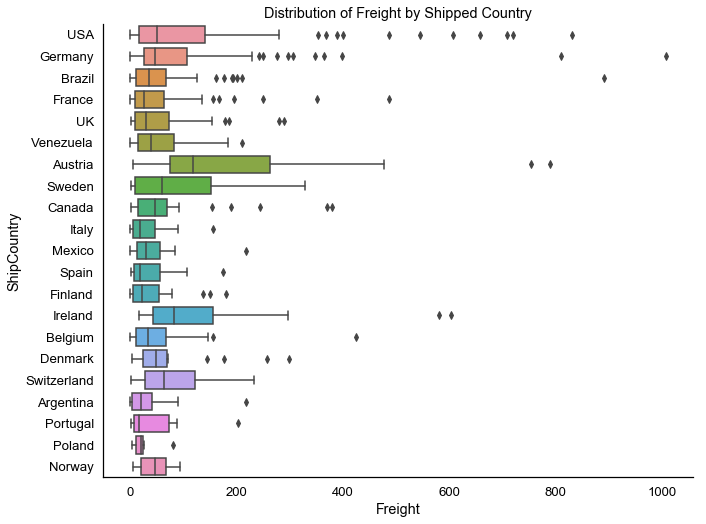

In [70]:
g = sns.catplot(y="ShipCountry", x="Freight", kind='box', orient='h',data=order_ship,
               order=d["'Order'"]['ShipCountry'].value_counts().index)
g.fig.set_figheight(8)
g.fig.set_figwidth(13)
plt.title('Distribution of Freight by Shipped Country')
plt.show()

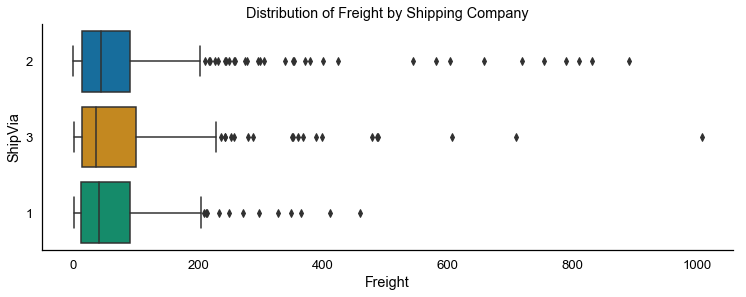

In [71]:
g = sns.catplot(y="ShipVia", x="Freight", kind='box', orient='h',data=order_ship, aspect=5,
               order=d["'Order'"]['ShipVia'].value_counts().index)
g.fig.set_figheight(4)
g.fig.set_figwidth(10)
plt.title('Distribution of Freight by Shipping Company')
plt.show()

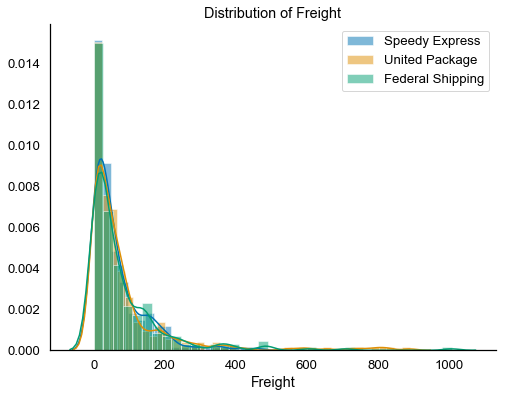

In [72]:
plt.figure(figsize=(8,6))
for i in range(3):
    sns.distplot(order_ship.loc[order_ship['ShipVia'] == i+1, 'Freight'], 
                 kde=True, hist_kws=dict(alpha=0.5),
                 label=d['Shipper']['CompanyName'][i])
plt.legend()
plt.title('Distribution of Freight')
plt.show()

In [73]:
d['Shipper']

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [74]:
order_ship.head()

,OrderId,Revenue,ShipRegion,ShipCountry,ShipVia,Freight,ShipRegion_num
0,10248,440.0,Western Europe,France,3,32.38,1.0
1,10249,1863.4,Western Europe,Germany,1,11.61,1.0
2,10250,1813.0,South America,Brazil,2,65.83,2.0
3,10251,670.8,Western Europe,France,1,41.34,1.0
4,10252,3730.0,Western Europe,Belgium,2,51.30,1.0


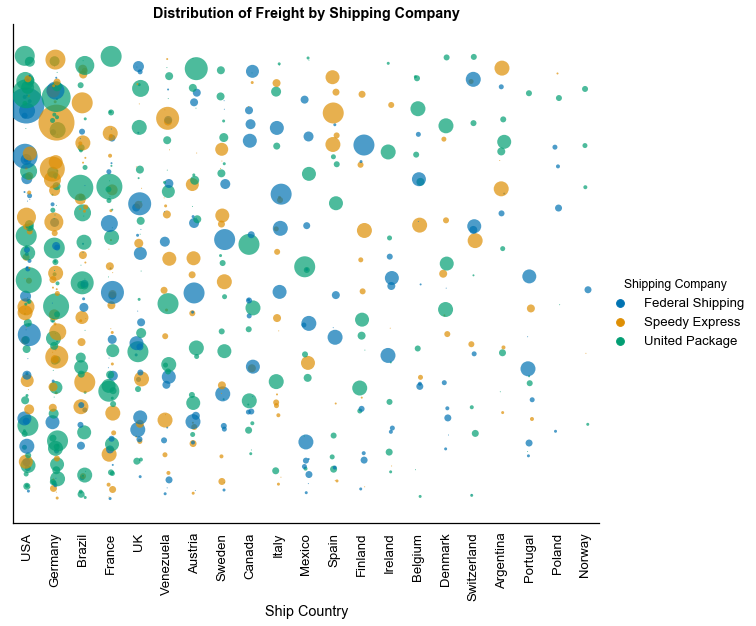

In [75]:
order_ship['Shipping Company'] = order_ship['ShipVia'].map({1 : d['Shipper']['CompanyName'][0],
                                                   2 : d['Shipper']['CompanyName'][1],
                                                   3 : d['Shipper']['CompanyName'][2]})
g = sns.catplot(x="ShipCountry", y='OrderId', hue="Shipping Company", kind='strip', orient='v',data=order_ship,
                height=8, aspect=1.2, alpha=0.7, s=np.round(order_ship['Freight']/10,0), legend_out=True,
               order=d["'Order'"]['ShipCountry'].value_counts().index)
g.set_xticklabels(rotation=90)
g.set_yticklabels([])
plt.title('Distribution of Freight by Shipping Company', weight='heavy')
plt.xlabel('Ship Country')
plt.ylabel('')
plt.show()

### 6c. Hypothesis Test

We use Welch's t-test to account for skewed distribution.

- $H_0$ : $Freight_{country1} = Freight_{country2}$
- $H_a$ : $Freight_{country1} < Freight_{country2}$

In [76]:
# run multiple t-tests to compare different shipping companies
results_5t = []
alpha = 0.05

companies = list(order_ship['ShipVia'].unique())
# comb = combinations(companies, 2)

for company1 in companies:
    for company2 in companies:
        sample1 = order_ship[order_ship['ShipVia'] == company1]['Freight']
        sample2 = order_ship[order_ship['ShipVia'] == company2]['Freight']

        result = stats.ttest_ind(sample1, sample2, equal_var=False)
        if result[1] /2  < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject'


        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_5t.append([company1, company2, result[1], concl, effect[0], effect[1], power])
    
results_df_5t = pd.DataFrame(results_5t, columns=['Company1', 'Company2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
# results_df.loc[results_df['Conclusion'] == 'Rejected']
results_df_5t

,Company1,Company2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,3,3,1.000000,Failed to Reject,0.000000,No Effect,0.050000
1,3,1,0.082499,Rejected,0.219160,Small,0.689782
2,3,2,0.562532,Failed to Reject,-0.068009,Small,0.128308
3,1,3,0.082499,Rejected,-0.219160,Small,0.689782
4,1,1,1.000000,Failed to Reject,0.000000,No Effect,0.050000
5,1,2,0.016834,Rejected,-0.275335,Small,0.904217
6,2,3,0.562532,Failed to Reject,0.068009,Small,0.128308
7,2,1,0.016834,Rejected,0.275335,Small,0.904217
8,2,2,1.000000,Failed to Reject,0.000000,No Effect,0.050000


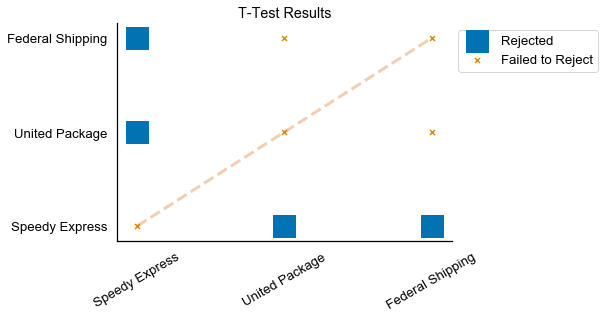

In [77]:
# t-test results
group1 = results_df_5t.loc[results_df_5t['Conclusion'] == 'Rejected']
group2 = results_df_5t.loc[results_df_5t['Conclusion'] == 'Failed to Reject']

plt.scatter('Company1', 'Company2', data=group1, marker='s', s=500, label='Rejected')
plt.scatter('Company1', 'Company2', data=group2, marker='x', s=25, label='Failed to Reject')
plt.plot(list(range(1,4)), list(range(1,4)), 'r--', linewidth=3, alpha=0.3)

plt.yticks(ticks=np.arange(1,4,1), labels=d['Shipper']['CompanyName'])
plt.xticks(ticks=np.arange(1,4,1), labels= d['Shipper']['CompanyName'], rotation=30)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('T-Test Results')
plt.show()

In [78]:
# run monte carlo simulation to compare different shipping companies
results_5m = []
alpha = 0.05

companies = list(order_ship['ShipVia'].unique())
companies_label = list(d['Shipper']['CompanyName'])

for company1 in companies:
    print('----')
    for company2 in companies:
        print('comparing {} and {}'.format(companies_label[int(company1-1)], companies_label[int(company2-1)]))
        sample1 = order_ship[order_ship['ShipVia'] == company1]['Freight']
        sample2 = order_ship[order_ship['ShipVia'] == company2]['Freight']

        p_val = monte_carlo(sample1, sample2, n=10000, greater='sample1', plot=False, print_progress=False)
        if p_val  < alpha:
            concl = 'Rejected'
        else:
            concl = 'Failed to Reject'


        effect = cal_cohens_d(sample1, sample2)
        power = cal_power(sample1, sample2, effect[0], alpha=alpha)
        results_5m.append([companies_label[int(company1-1)], companies_label[int(company2-1)], 
                           p_val, concl, effect[0], effect[1], power])
    
results_df_5m = pd.DataFrame(results_5m, columns=['Company1', 'Company2', 'P_Value','Conclusion',
                                            'Effect Size','Effect Size Flag','Power'])
# results_df.loc[results_df['Conclusion'] == 'Rejected']
results_df_5m

----
comparing Federal Shipping and Federal Shipping
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.5
comparing Federal Shipping and Speedy Express
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.04
comparing Federal Shipping and United Package
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 0.72
----
comparing Speedy Express and Federal Shipping
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 0.96
comparing Speedy Express and Speedy Express
  Testing if sample1 is greater than sample2 where difference = mean(sample1) - mean(sample2)
  P_value is 0.5
comparing Speedy Express and United Package
  Testing if sample1 is greater than sample2 where difference = mean(sample2) - mean(sample1)
  P_value is 0.99
----
comparing United Package and Federal Ship

,Company1,Company2,P_Value,Conclusion,Effect Size,Effect Size Flag,Power
0,Federal Shipping,Federal Shipping,0.4987,Failed to Reject,0.000000,No Effect,0.050000
1,Federal Shipping,Speedy Express,0.0433,Rejected,0.219160,Small,0.689782
2,Federal Shipping,United Package,0.7160,Failed to Reject,-0.068009,Small,0.128308
3,Speedy Express,Federal Shipping,0.9590,Failed to Reject,-0.219160,Small,0.689782
4,Speedy Express,Speedy Express,0.5016,Failed to Reject,0.000000,No Effect,0.050000
5,Speedy Express,United Package,0.9880,Failed to Reject,-0.275335,Small,0.904217
6,United Package,Federal Shipping,0.2867,Failed to Reject,0.068009,Small,0.128308
7,United Package,Speedy Express,0.0127,Rejected,0.275335,Small,0.904217
8,United Package,United Package,0.5040,Failed to Reject,0.000000,No Effect,0.050000


The results show that Federal Shipping is significantly different from other shipping companies, but the effect sizes are small.